In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data/drone.csv")

In [3]:
defined_features = ['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a', 
                    'discharged_mah', 'remaining', 'scale', 'load', 'ram_usage']
target_variable = 'warning'
subset = df[defined_features+[target_variable]]


In [4]:
subset.head()

,voltage_v,voltage_filtered_v,current_a,current_filtered_a,discharged_mah,remaining,scale,load,ram_usage,warning
0,23.821001,23.832287,0.1612,0.231098,2478.4924,0.868972,1.018116,0.636926,0.789424,0
1,23.681600,23.805693,0.4464,0.261076,2478.5286,0.872252,1.017655,0.741170,0.850598,0
2,23.583200,23.732930,0.8680,0.530416,2478.6260,0.857639,1.019714,0.741170,0.850598,0
3,23.534000,23.650160,0.9176,0.848289,2478.7825,0.837432,1.022576,0.719303,0.850598,0
4,23.566800,23.614992,0.9176,0.879427,2478.9077,0.829972,1.023636,0.719303,0.850598,0


In [5]:
subset.shape

(5725, 10)

In [6]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   voltage_v           5725 non-null   float64
 1   voltage_filtered_v  5725 non-null   float64
 2   current_a           5725 non-null   float64
 3   current_filtered_a  5725 non-null   float64
 4   discharged_mah      5725 non-null   float64
 5   remaining           5725 non-null   float64
 6   scale               5725 non-null   float64
 7   load                5724 non-null   float64
 8   ram_usage           5724 non-null   float64
 9   warning             5725 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 447.4 KB


In [7]:
print("Data Types:  ", subset.dtypes)

Data Types:   voltage_v             float64
voltage_filtered_v    float64
current_a             float64
current_filtered_a    float64
discharged_mah        float64
remaining             float64
scale                 float64
load                  float64
ram_usage             float64
warning                 int64
dtype: object


In [8]:
print("Missing Values:  ", subset.isnull().sum())
subset=subset.fillna(0)
print("Missing Values:  ", subset.isnull().sum())

Missing Values:   voltage_v             0
voltage_filtered_v    0
current_a             0
current_filtered_a    0
discharged_mah        0
remaining             0
scale                 0
load                  1
ram_usage             1
warning               0
dtype: int64
Missing Values:   voltage_v             0
voltage_filtered_v    0
current_a             0
current_filtered_a    0
discharged_mah        0
remaining             0
scale                 0
load                  0
ram_usage             0
warning               0
dtype: int64


In [9]:
duplicates = subset.duplicated().sum()
print(duplicates)

0


In [10]:
subset.describe()

,voltage_v,voltage_filtered_v,current_a,current_filtered_a,discharged_mah,remaining,scale,load,ram_usage,warning
count,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000
mean,17.996774,18.013255,16.099150,16.083609,568.838936,0.081593,1.143835,0.708032,0.854880,2.674236
std,1.980443,1.948583,5.380619,5.363591,602.918011,0.230874,0.037450,0.013558,0.011941,0.929132
min,14.276200,16.118723,0.124000,0.171426,0.664198,0.000000,1.017655,0.000000,0.000000,0.000000
25%,16.990400,17.034609,17.037600,17.101912,144.849820,0.000000,1.157143,0.705065,0.854744,3.000000
50%,17.293800,17.250465,18.054400,18.075237,400.255070,0.000000,1.157143,0.709059,0.855424,3.000000
75%,17.802200,17.703796,18.810800,18.788374,792.113160,0.000000,1.157143,0.712940,0.857259,3.000000
max,23.829200,23.832287,22.220800,21.309430,3021.938200,0.872252,1.157143,0.756826,0.859570,3.000000


In [11]:
correlations = subset.corr()[target_variable].sort_values()
print("Correlations with Target Variable:\n", correlations)

Correlations with Target Variable:
 remaining            -0.942441
voltage_filtered_v   -0.908926
voltage_v            -0.858316
load                  0.127846
ram_usage             0.177305
discharged_mah        0.269458
current_a             0.872333
current_filtered_a    0.895547
scale                 0.944046
warning               1.000000
Name: warning, dtype: float64


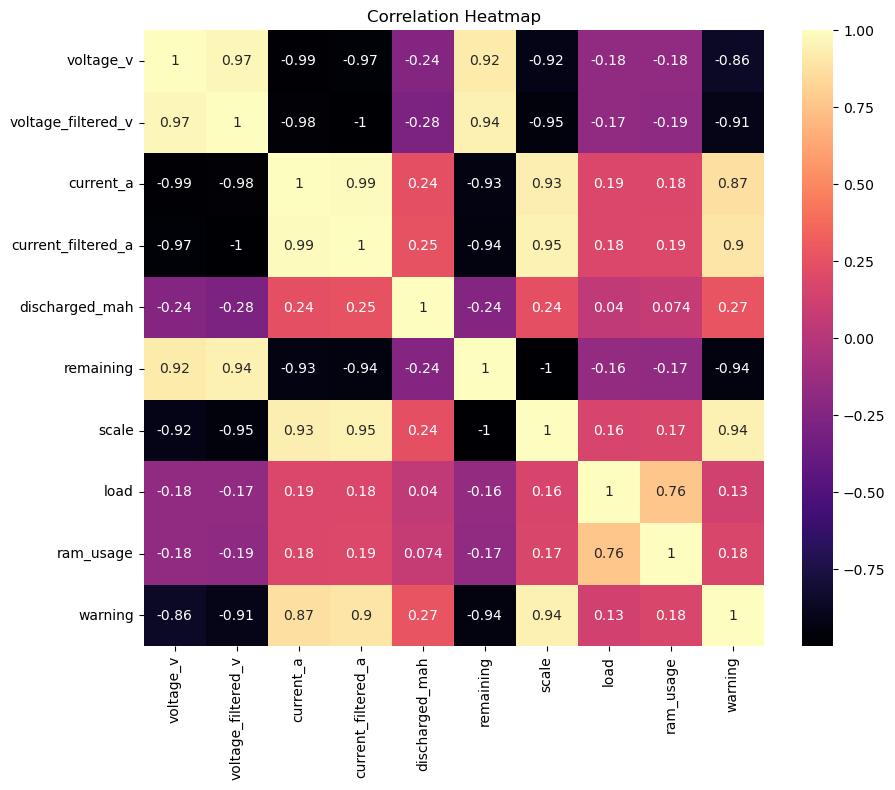

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset.corr(), annot=True, cmap='magma')
plt.title("Correlation Heatmap")
plt.show()

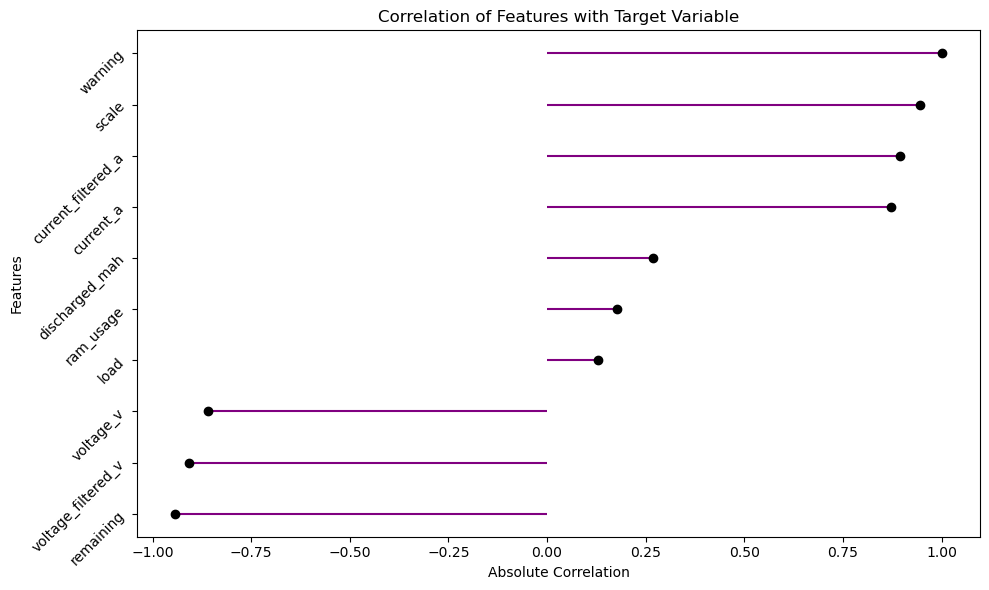

In [13]:
features = correlations.index
correlation_values = correlations.values
plt.figure(figsize=(10, 6))
plt.hlines(y=features, xmin=0, xmax=correlation_values, color='purple')
plt.plot(correlation_values, features, "o", color='black')
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
X = subset[defined_features]
y = subset[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=log_reg, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected Features:", list(selected_features_rfe))

Selected Features: ['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a', 'remaining']


In [15]:
print("Before SMOTE, counts of each warning level:\n", y_train.value_counts())

Before SMOTE, counts of each warning level:
 warning
3    4075
0     487
1      15
2       3
Name: count, dtype: int64


In [16]:
smote = SMOTE(random_state=42, k_neighbors=2)
print("\nApplying SMOTE...")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE applied successfully.")

print("\nAfter SMOTE, counts of each warning level:\n", y_train_resampled.value_counts())


Applying SMOTE...
SMOTE applied successfully.

After SMOTE, counts of each warning level:
 warning
0    4075
3    4075
2    4075
1    4075
Name: count, dtype: int64


In [17]:
print("\n--- Training Logistic Regression on Balanced Data ---")
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_resampled[selected_features_rfe], y_train_resampled)
y_pred_log_smote = log_reg_smote.predict(X_test[selected_features_rfe])
print("\nClassification Report (Logistic Regression with SMOTE):\n")
print(classification_report(y_test, y_pred_log_smote))


--- Training Logistic Regression on Balanced Data ---

Classification Report (Logistic Regression with SMOTE):

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       121
           1       0.27      1.00      0.43         3
           2       0.08      1.00      0.14         2
           3       1.00      0.96      0.98      1019

    accuracy                           0.96      1145
   macro avg       0.56      0.97      0.61      1145
weighted avg       0.98      0.96      0.97      1145



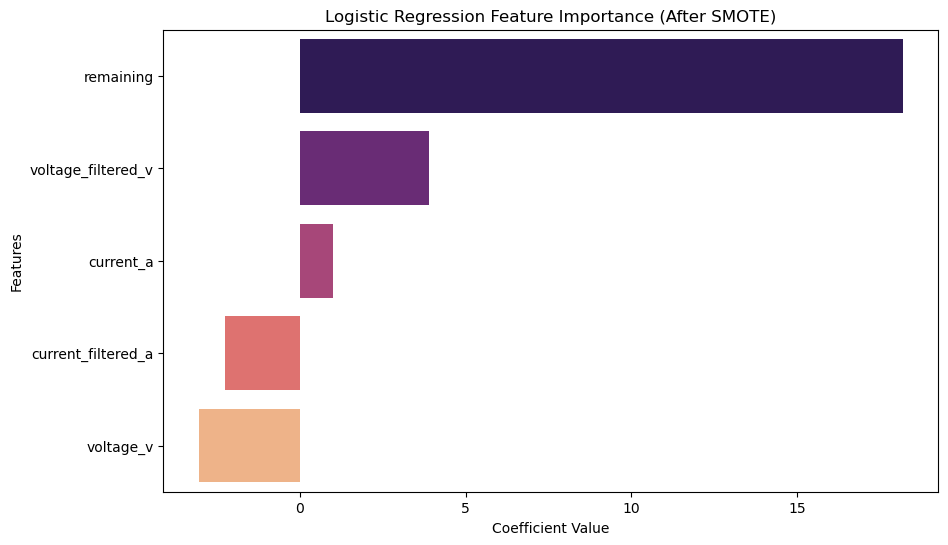

In [18]:
coefficients_smote = log_reg_smote.coef_
feature_importance_log = pd.Series(coefficients_smote[0], index=selected_features_rfe).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_log.values, y=feature_importance_log.index, palette='magma')
plt.title('Logistic Regression Feature Importance (After SMOTE)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


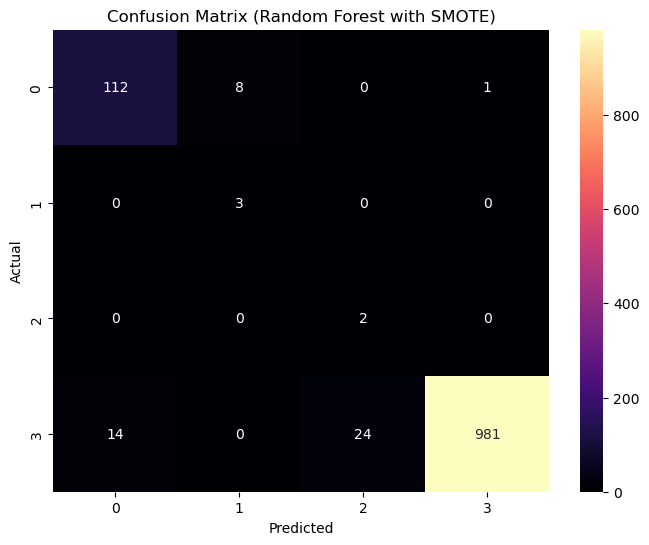

In [19]:
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_log_smote)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_smote, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix (Random Forest with SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



--- Training Random Forest on Balanced Data ---

Classification Report (Random Forest with SMOTE):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       121
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00      1019

    accuracy                           1.00      1145
   macro avg       1.00      1.00      1.00      1145
weighted avg       1.00      1.00      1.00      1145


Confusion Matrix for Random Forest with SMOTE:


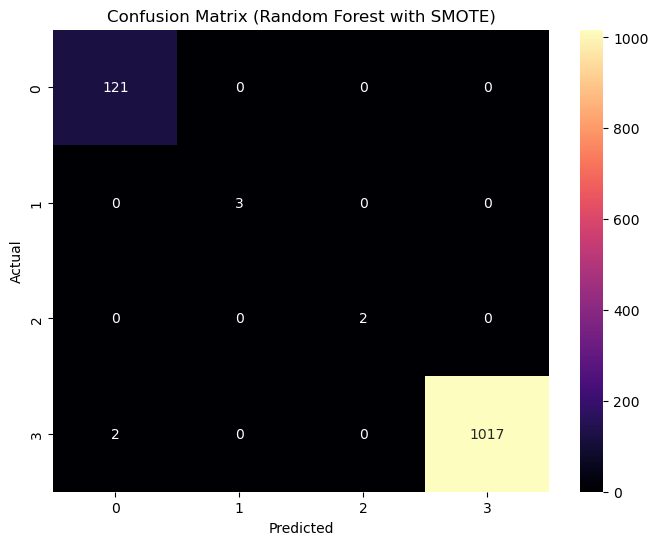

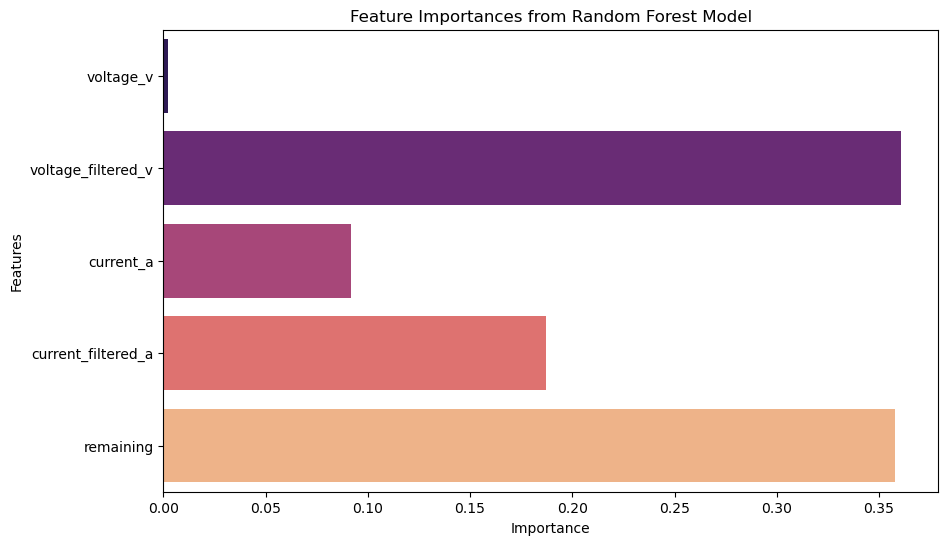

In [20]:
print("\n--- Training Random Forest on Balanced Data ---")
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_resampled[selected_features_rfe], y_train_resampled)


y_pred_rf_smote = rf_model_smote.predict(X_test[selected_features_rfe])


print("\nClassification Report (Random Forest with SMOTE):\n")
print(classification_report(y_test, y_pred_rf_smote))


print("\nConfusion Matrix for Random Forest with SMOTE:")
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_smote, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix (Random Forest with SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

feature_importances = rf_model_smote.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=selected_features_rfe, orient='h', palette="magma")
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline

rf_model_cv = RandomForestClassifier(n_estimators=100, random_state=42)
smote_cv = SMOTE(random_state=42, k_neighbors=2)
pipeline = ImbPipeline([('smote', smote_cv), ('classifier', rf_model_cv)])
cv_scores = cross_val_score(pipeline, X[selected_features_rfe], y, cv=5, scoring='f1_weighted')
print("Cross-Validation F1 Scores:", cv_scores)
print(f"Average Cross-Validation F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation F1 Scores: [0.99927198 0.99485832 0.99912821 0.99382946 0.99739402]
Average Cross-Validation F1 Score: 0.9969
Standard Deviation: 0.0022
